# <font color=blue>OPTIM/OPTECH Laboratory Project Session III: </font>
## <font color=blue>Multi-Objective Optimization</font>

### `MASTEAM`: Master's degree in Applied Telecommunications and Engineering Management
### `MATT`: Master's degree in Advanced Telecommunication Technologies
### `CoDaS`: Erasmus Mundus master's degree in Communications, Engineering and Data Science

#####  Castelldefels School of Telecommunications and Aerospace Engineering (EETAC)

**<font color=teal>Cristina Cervelló-Pastor (cristina.cervello@upc.edu)</font>**

<div class="alert alert-block alert-info">

<font size="4"><font color=blue><b>PROBLEM:</b></font></font>
<br />
<br />
Define the model to compute paths in the pan-European meshed network defined in European COST 266 project with a total of 37 nodes and 28 bidirectional links covering many European countries, based on multi-commodity flow optimization.
    
The **objective** of this problem is **to compute a path to transmit a demand minimizing the energy consumption and the maximum link utilization** at the same time.

Different methods for solving multi-objective problems will be applied.

</div>

In [1]:
!pip install Pyomo
!apt-get install -y -qq glpk-utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.4 MB/s eta 0:00:00
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 123621 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package

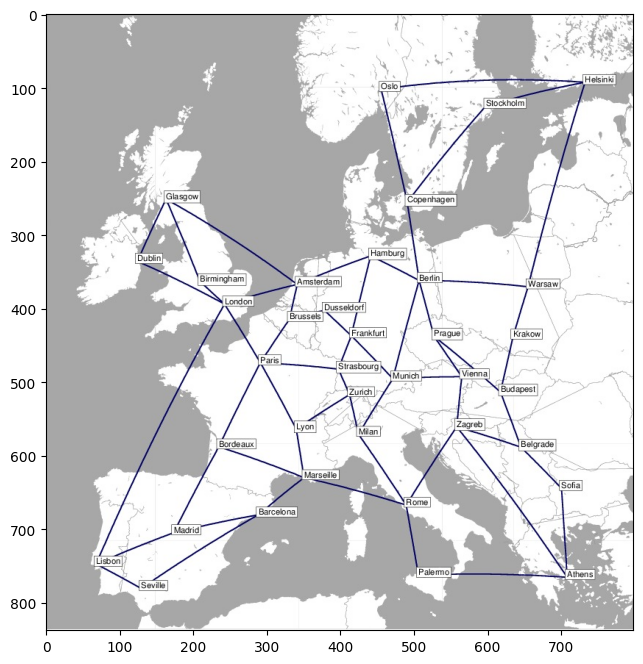

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))

img = Image.open('cost266.jpg')
plt.imshow(img)

### FUNCTION TO PLOT RESULTS

In [3]:
import matplotlib.pyplot as plt


def sort_links(instance, d):
    i = instance.source[d]
    path=[]
    begin = True
    while begin:
        begin = False
        for j in instance.V:
            if (i,j) in instance.E:
                if instance.f[i,j,d].value != 0:
                    if i not in path:
                        path.append(i)
                    if j not in path:
                        path.append(j)
                    i = j
                    begin = True
                    break
    return path


def print_results(instance):
    print("\n=====================")
    print("UTILIZATION PER LINK")
    print("=====================")
    for i in instance.V:
        for j in instance.V:
            if i==j: continue
            if (i,j) in instance.E:
                s = 0
                for d in instance.D:
                    s = s + instance.f[i,j,d].value*instance.demand[d]
                if s != 0:
                    print("Link (",i,', ', j, ") ", \
                          format(s/instance.capacity[i,j]*100, ".2f"),'%',sep='')


def get_path(instance):
    path = []
    for d in instance.D:
        i = instance.source[d]
        for j in instance.V:
            if (i,j) in instance.E:
                if instance.f[i,j,d].value != 0:
                    p=sort_links(instance, d)
                    path.append(p)
                    print('\nPATH: ',p,'\n')
                    break

    return (path)


def show_paths(paths,color,custom_node_positions=None):
    plt.figure()

    if custom_node_positions==None:
        pos = nx.spring_layout(G)
    else:
        pos=custom_node_positions

    list_edges = list(G.edges())
    list_nodes = list(G.nodes())
    links = []
    links = [l for l in list_edges if (l[1],l[0]) not in links]

    edges_paths=[]
    for i,p in enumerate(paths):
        edges_paths.append(list(zip(p,p[1:])))

    edge_colors = ['black' for edge in G.edges()]
    edge_style = ['solid' for edge in links]
    weights = [0.5 for edge in G.edges()]

    for i,p in enumerate(edges_paths):
        for edge in p:
            edge_colors[list_edges.index(edge)] = color
            # the same color in the bidirectional link
            edge_colors[list_edges.index((edge[1],edge[0]))] = color
            if edge in links:
                edge_style[links.index(edge)] = 'dashed'
            weights[list_edges.index(edge)]=2

    nodecol = ['steelblue' for node in G.nodes()]
    node_size = [100 for node in G.nodes()]

    for i,p in enumerate(paths):
        for node in G.nodes():
            if node in p:
                nodecol[list_nodes.index(node)] = color
                node_size[list_nodes.index(node)]+=150

    nx.draw(G,pos,arrowstyle='-',with_labels = True,font_size = 8, font_color = 'black',\
            edge_color = edge_colors,  width=weights, style=edge_style, node_size = node_size,\
            node_shape = 'o', node_color = nodecol)


<div class="alert alert-block alert-info">
<font size="4"><font color=blue><b>DEFINE THE MODEL:</b></font></font>

<br /><br />



$G(V,E)$ $\longrightarrow$ $V$ set of nodes (vertices), $E$ set of links (edges or arcs)
<br /> <br />
$(i,j)\in E$ link between nodes $i$ and $j$
<br /> <br />
$w_{ij}$ weight or marginal cost of link $(i,j)$
<br /> <br />
$d_{i,j}$ link distance
<br /> <br />
$C_{ij}$ capacity of link $(i,j)$
<br /> <br />
$D$ set of traffic demands  $\longrightarrow$ $h_d$ traffic demand $d$ from source node $s_d$ to destination node $t_d$
<br /> <br />


<br /> <br />

$\textbf{Variables:}$
<br /> <br />
$x_{ij}$ binary variable indicating if link $(i,j)$ is active or not
<br /> <br />
$f_{ij}^d$ binary variable indicating if link $(i,j)$ is active or not due to demand $d$
<br /> <br />


$\mathit{Utilization}$ - Maximum link Utilization
<br /> <br />

$\mathit{Energy}$ - Total energy consumption measured by the number of active links
<br /> <br />

\begin{align}
&\\
\mbox{minimize } &\ \mathit{Utilization}  &\\[8pt]
\mbox{minimize } & \mathit{Energy} &\\[8pt]
\mbox{such that }& \sum_{(i,j)\in E} f_{ij}^d - \sum_{(j,i)\in E} f_{ji}^d= 1\quad&&  \forall d \in D,\ \forall i = s_d&\nonumber\\[8pt]
& \sum_{(i,j)\in E} f_{ij}^d - \sum_{(j,i)\in E} f_{ji}^d= 1\quad&&  \forall d \in D,\ \forall j = t_d\ \qquad \mbox{(redundant constraints)}&&\nonumber\\[8pt]
& \sum_{(i,j)\in E} f_{ij}^d - \sum_{(j,i)\in E} f_{ji}^d = 0\quad&&   \forall d \in D,\ \forall i \neq \{s_d,t_d\}&\nonumber\\[8pt]
& \sum_{d \in D}f_{ij}^{d}\cdot h_d <= x_{ij}\cdot C_{ij}\quad&&\forall (i,j)\in E&\nonumber\\[8pt]
&\mathit{Utilization} \geq \frac{\sum_{d \in D}f_{ij}^{d}\cdot h_d}{C_{ij}}\quad&&\forall (i,j)\in E&\nonumber\\[8pt]
&\mathit{Energy} = \sum_{(i,j)\in E} x_{ij}&&\nonumber\\[8pt]
& x_{ij},\ f_{ij}^d\ \mbox{binary} \quad&&  \forall d \in D,\ \forall (i,j)\in E.&\nonumber
\end{align}



<br />
</div>

In [4]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.core import Var

import networkx as nx

In [5]:
######################
## CREATE THE MODEL ##
######################

model = AbstractModel()


######################
## MODEL PARAMETERS ##
######################

# Set of network nodes
model.V = Set()

# Set of network edges
model.E = Set(dimen=2)

# Latitude and longitude of nodes
model.latitude = Param(model.V, within=Any)
model.longitude = Param(model.V, within=Any)


# Flow capacity limits of links
model.capacity = Param(model.E, within=NonNegativeReals)

# Weight or cost of each link
model.linkcost = Param(model.E, within=NonNegativeReals)

# Set of Demands
model.D = Set()

# Source nodes
model.source = Param(model.D, within=Any)

# Destination nodes
model.destination = Param(model.D, within=Any)

# Traffic demand value
model.demand = Param(model.D, within=NonNegativeIntegers)

model.w1 = Param(initialize=0.2)



#####################
## MODEL VARIABLES ##
#####################

# If x[i,j)]=1 link (i,j) is used
model.x = Var(model.E, within=Binary, initialize=0)

# if f[i,j,d]=1, link (i,j) is used for demand d
model.f = Var(model.E, model.D, within=Binary, initialize=0)

# Energy savings (number of active links)
model.Energy = Var(within=NonNegativeIntegers, initialize=0)

# Maximum link Utilization
model.Utilization = Var(within=NonNegativeReals, bounds=(0,1), initialize=0)


########################
## OBJECTIVE FUNCTION ##
########################

'''OBJECTIVE FUNCTION 1'''
# Minimize the Energy consumption (the number of active links)
def EnergyConsumption_rule(model):
    return model.Energy

model.EnergyConsumption = Objective(rule=EnergyConsumption_rule, sense=minimize)


'''OBJECTIVE FUNCTION 2'''
# Minimize the maximum link utilization
def MaxUtilization_rule(model):
    return model.Utilization

model.MaxUtilization = Objective(rule=MaxUtilization_rule, sense=minimize)


# ACTIVATE OR DEACTIVATE the objective function according the exercise
model.EnergyConsumption.deactivate()
model.MaxUtilization.activate()


#################
## CONSTRAINTS ##
#################

'''CONSTRAINT 1'''
# Flow conservation constraint at each node
def flow_rule(model, k, d):

    inFlow  = sum(model.f[j,i,d] for (j,i) in model.E if i == k)
    if (k == model.source[d]):
        inFlow = inFlow + 1

    outFlow = sum(model.f[i,j,d] for (i,j) in model.E if i == k)
    if (k == model.destination[d]):
        outFlow = outFlow + 1

    return inFlow == outFlow

model.flow = Constraint(model.V, model.D, rule=flow_rule)



'''CONSTRAINT 2'''
def activelinks_rule(model, i, j):
    return sum(model.f[i,j,d]*model.demand[d] for d in model.D) <= model.x[i, j]* model.capacity[i, j]

model.activelinks = Constraint(model.E,  rule=activelinks_rule)



'''CONSTRAINT 3'''
def Utility_rule(model,i,j):
    return model.Utilization >= (sum(model.f[i,j,d]*model.demand[d] for d in model.D))/ model.capacity[i, j]

model.Utility = Constraint(model.E, rule=Utility_rule)



'''CONSTRAINT 4'''
def EnergyC_rule(model):
    return model.Energy == sum(model.x[i,j] for (i, j) in model.E)

model.EnergyC = Constraint(rule=EnergyC_rule)



### SOLVE THE MODEL

In [6]:
opt = SolverFactory('glpk')
instance = model.create_instance('./OPTIM-OPTECH-ProjectSession3.dat')
results = opt.solve(instance)
instance.solutions.load_from(results)

### PRINT RESULTS

In [7]:
print ("\nMAXIMUM LINK UTILIZATION:", instance.Utilization.value)
print ("\nENERGY CONSUMPTION:", instance.Energy.value)


MAXIMUM LINK UTILIZATION: 0.212856534695615

ENERGY CONSUMPTION: 7.0



UTILIZATION PER LINK
Link (Barcelona, Madrid) 14.62%
Link (Bordeaux, Marseille) 14.70%
Link (Madrid, Bordeaux) 13.32%
Link (Marseille, Rome) 12.25%
Link (Milan, Munich) 21.29%
Link (Munich, Berlin) 14.68%
Link (Rome, Milan) 15.43%

PATH:  ['Barcelona', 'Madrid', 'Bordeaux', 'Marseille', 'Rome', 'Milan', 'Munich', 'Berlin'] 



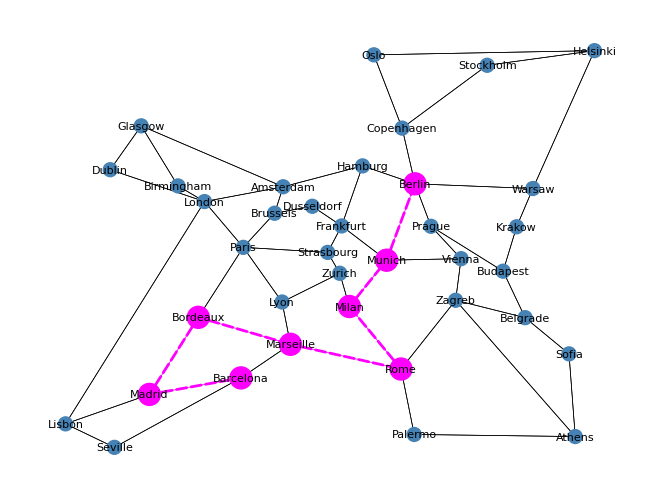

In [8]:
# Create the digraph with nodes and links attributes
G = nx.DiGraph()

lnodes=list((i,{'lat':instance.latitude[i], 'long':instance.longitude[i]}) for i in list(instance.V))
G.add_nodes_from(lnodes)

ledges = list((i,j,{'cap':instance.capacity[i,j]}) for i,j in list(instance.E))
G.add_edges_from(ledges)

# Position of nodes according to latitude and longitude
node_pos = {i:(instance.latitude[i], instance.longitude[i]) for i in list(instance.V)}

# Print results
print_results(instance)
path = get_path(instance)

# Show paths on the graph
show_paths(path,'magenta',node_pos)

<div class="alert alert-block  alert-success">
<font size="4"><font color=green><b>EXERCISES</b></font></font>
</div>

### <font color=blue><b>EXERCISE 1</b></font>.-


#### What is the path from Barcelona to Berlin for a flow of 10000 units in case of having as a optimization objective function....?

#### a) only the energy consumption
#### b) only the maximum link utilization

#### In both cases obtain the value of the energy consumption and the value of the maximum link utilization

a) only the energy consumption:</span>

PATH:  ['Barcelona', 'Marseille', 'Rome', 'Milan', 'Munich', 'Berlin']. MAXIMUM LINK UTILIZATION: 0.4649, ENERGY CONSUMPTION: 5.0 </span>


b) only the maximum link utilization:</span>

PATH:  ['Barcelona', 'Madrid', 'Bordeaux', 'Marseille', 'Rome', 'Milan', 'Munich', 'Berlin']. MAXIMUM LINK UTILIZATION: 0.2129, ENERGY CONSUMPTION: 7.0




-------------------------------------------------------------------------------------------------------------------
<font size="3"><font color=blue><b> For the following exercises consider that our objective functions to optimize are at the same time the maximum link utilization and the energy consumption. In each exercise, add the objective function and/or variables, parameters, and/or constraints that are necessary. </b></font>


### <font color=blue><b>EXERCISE 2</b></font>.-

#### Use the Weighted Sum Method to find the path for different values of w. Obtain the energy consumption and the maximum utilization for different weight values. Determine the Pareto Front indicating the different feasible solutions. Determine also what would be the ideal point, the nadir point and the worst point.

In [11]:
######################
## CREATE THE MODEL ##
######################

model = AbstractModel()


######################
## MODEL PARAMETERS ##
######################

# Set of network nodes
model.V = Set()

# Set of network edges
model.E = Set(dimen=2)

# Latitude and longitude of nodes
model.latitude = Param(model.V, within=Any)
model.longitude = Param(model.V, within=Any)


# Flow capacity limits of links
model.capacity = Param(model.E, within=NonNegativeReals)

# Weight or cost of each link
model.linkcost = Param(model.E, within=NonNegativeReals)

# Set of Demands
model.D = Set()

# Source nodes
model.source = Param(model.D, within=Any)

# Destination nodes
model.destination = Param(model.D, within=Any)

# Traffic demand value
model.demand = Param(model.D, within=NonNegativeIntegers)

model.w1 = Param(initialize=0.2)



#####################
## MODEL VARIABLES ##
#####################

# If x[i,j)]=1 link (i,j) is used
model.x = Var(model.E, within=Binary, initialize=0)

# if f[i,j,d]=1, link (i,j) is used for demand d
model.f = Var(model.E, model.D, within=Binary, initialize=0)

# Energy savings (number of active links)
model.Energy = Var(within=NonNegativeIntegers, initialize=0)

# Maximum link Utilization
model.Utilization = Var(within=NonNegativeReals, bounds=(0,1), initialize=0)


########################
## OBJECTIVE FUNCTION ##
########################

'''OBJECTIVE FUNCTION 1'''
# Minimize the Energy consumption (the number of active links)
def EnergyConsumption_rule(model):
    return model.Energy

model.EnergyConsumption = Objective(rule=EnergyConsumption_rule, sense=minimize)


'''OBJECTIVE FUNCTION 2'''
# Minimize the maximum link utilization
def MaxUtilization_rule(model):
    return model.Utilization

model.MaxUtilization = Objective(rule=MaxUtilization_rule, sense=minimize)

maxE = 7
maxU = 0.464900046490005
w1 = .7
w2 = 1-w1
def weighted_rule(model):
    return (w1*(model.Energy/maxE)) + (w2*(model.Utilization/maxU))

model.Weighted = Objective(rule=weighted_rule, sense=minimize)


# ACTIVATE OR DEACTIVATE the objective function according the exercise
model.EnergyConsumption.deactivate()
model.MaxUtilization.deactivate()
model.Weighted.activate()



#################
## CONSTRAINTS ##
#################

'''CONSTRAINT 1'''
# Flow conservation constraint at each node
def flow_rule(model, k, d):

    inFlow  = sum(model.f[j,i,d] for (j,i) in model.E if i == k)
    if (k == model.source[d]):
        inFlow = inFlow + 1

    outFlow = sum(model.f[i,j,d] for (i,j) in model.E if i == k)
    if (k == model.destination[d]):
        outFlow = outFlow + 1

    return inFlow == outFlow

model.flow = Constraint(model.V, model.D, rule=flow_rule)



'''CONSTRAINT 2'''
def activelinks_rule(model, i, j):
    return sum(model.f[i,j,d]*model.demand[d] for d in model.D) <= model.x[i, j]* model.capacity[i, j]

model.activelinks = Constraint(model.E,  rule=activelinks_rule)



'''CONSTRAINT 3'''
def Utility_rule(model,i,j):
    return model.Utilization >= (sum(model.f[i,j,d]*model.demand[d] for d in model.D))/ model.capacity[i, j]

model.Utility = Constraint(model.E, rule=Utility_rule)



'''CONSTRAINT 4'''
def EnergyC_rule(model):
    return model.Energy == sum(model.x[i,j] for (i, j) in model.E)

model.EnergyC = Constraint(rule=EnergyC_rule)

opt = SolverFactory('glpk')
instance = model.create_instance('./OPTIM-OPTECH-ProjectSession3.dat')
results = opt.solve(instance)
instance.solutions.load_from(results)
# util = []
# en = []
util.append(instance.Utilization.value)
en.append(instance.Energy.value)
print ("\nMAXIMUM LINK UTILIZATION:", instance.Utilization.value)
print ("\nENERGY CONSUMPTION:", instance.Energy.value)


MAXIMUM LINK UTILIZATION: 0.291630212890055

ENERGY CONSUMPTION: 6.0


In [12]:
print(util,en)

[0.291630212890055, 0.291630212890055] [6.0, 6.0]


So, the pareto front has the points (0.46, 5.0), (0.21, 7.0)and (0.29, 6.0). Ideal point is (0.21, 5.0). Nadir point (0.46, 7.0). Worst point is (1, longest path)

### <font color=blue><b>EXERCISE 3</b></font>.-

#### Use the $\epsilon$-Constraint Method to find the paths. Determine what should be the $\epsilon$ value for obtainig all the points of the Pareto Front.

In [13]:
######################
## CREATE THE MODEL ##
######################

model = AbstractModel()


######################
## MODEL PARAMETERS ##
######################

# Set of network nodes
model.V = Set()

# Set of network edges
model.E = Set(dimen=2)

# Latitude and longitude of nodes
model.latitude = Param(model.V, within=Any)
model.longitude = Param(model.V, within=Any)


# Flow capacity limits of links
model.capacity = Param(model.E, within=NonNegativeReals)

# Weight or cost of each link
model.linkcost = Param(model.E, within=NonNegativeReals)

# Set of Demands
model.D = Set()

# Source nodes
model.source = Param(model.D, within=Any)

# Destination nodes
model.destination = Param(model.D, within=Any)

# Traffic demand value
model.demand = Param(model.D, within=NonNegativeIntegers)

model.w1 = Param(initialize=0.2)



#####################
## MODEL VARIABLES ##
#####################

# If x[i,j)]=1 link (i,j) is used
model.x = Var(model.E, within=Binary, initialize=0)

# if f[i,j,d]=1, link (i,j) is used for demand d
model.f = Var(model.E, model.D, within=Binary, initialize=0)

# Energy savings (number of active links)
model.Energy = Var(within=NonNegativeIntegers, initialize=0)

# Maximum link Utilization
model.Utilization = Var(within=NonNegativeReals, bounds=(0,1), initialize=0)


model.epsilon1 = Param(initialize=.4)
model.epsilon2 = Param(initialize=5)

########################
## OBJECTIVE FUNCTION ##
########################

'''OBJECTIVE FUNCTION 1'''
# Minimize the Energy consumption (the number of active links)
def EnergyConsumption_rule(model):
    return model.Energy

model.EnergyConsumption = Objective(rule=EnergyConsumption_rule, sense=minimize)


'''OBJECTIVE FUNCTION 2'''
# Minimize the maximum link utilization
def MaxUtilization_rule(model):
    return model.Utilization

model.MaxUtilization = Objective(rule=MaxUtilization_rule, sense=minimize)


# ACTIVATE OR DEACTIVATE the objective function according the exercise
model.EnergyConsumption.activate()
model.MaxUtilization.deactivate()


#################
## CONSTRAINTS ##
#################


'''epsilon 1'''
def epsilon_1(model):
    return model.Utilization <= model.epsilon1

model.epsilon_rule_1 = Constraint(rule=epsilon_1)

'''epsilon 2
def epsilon_2(model):
    return model.Energy <= model.epsilon2

model.epsilon_rule_2 = Constraint(rule=epsilon_2)'''


'''CONSTRAINT 1'''
# Flow conservation constraint at each node
def flow_rule(model, k, d):

    inFlow  = sum(model.f[j,i,d] for (j,i) in model.E if i == k)
    if (k == model.source[d]):
        inFlow = inFlow + 1

    outFlow = sum(model.f[i,j,d] for (i,j) in model.E if i == k)
    if (k == model.destination[d]):
        outFlow = outFlow + 1

    return inFlow == outFlow

model.flow = Constraint(model.V, model.D, rule=flow_rule)



'''CONSTRAINT 2'''
def activelinks_rule(model, i, j):
    return sum(model.f[i,j,d]*model.demand[d] for d in model.D) <= model.x[i, j]* model.capacity[i, j]

model.activelinks = Constraint(model.E,  rule=activelinks_rule)



'''CONSTRAINT 3'''
def Utility_rule(model,i,j):
    return model.Utilization >= (sum(model.f[i,j,d]*model.demand[d] for d in model.D))/ model.capacity[i, j]

model.Utility = Constraint(model.E, rule=Utility_rule)



'''CONSTRAINT 4'''
def EnergyC_rule(model):
    return model.Energy == sum(model.x[i,j] for (i, j) in model.E)

model.EnergyC = Constraint(rule=EnergyC_rule)

opt = SolverFactory('glpk')
instance = model.create_instance('./OPTIM-OPTECH-ProjectSession3.dat')
results = opt.solve(instance)
instance.solutions.load_from(results)
# util = []
# en = []
util.append(instance.Utilization.value)
en.append(instance.Energy.value)
print ("\nMAXIMUM LINK UTILIZATION:", instance.Utilization.value)
print ("\nENERGY CONSUMPTION:", instance.Energy.value)


MAXIMUM LINK UTILIZATION: 0.291630212890055

ENERGY CONSUMPTION: 6.0



UTILIZATION PER LINK
Link (Amsterdam, Hamburg) 20.13%
Link (Barcelona, Madrid) 14.62%
Link (Hamburg, Berlin) 29.16%
Link (Lisbon, London) 5.62%
Link (London, Amsterdam) 20.58%
Link (Madrid, Lisbon) 14.80%

PATH:  ['Barcelona', 'Madrid', 'Lisbon', 'London', 'Amsterdam', 'Hamburg', 'Berlin'] 



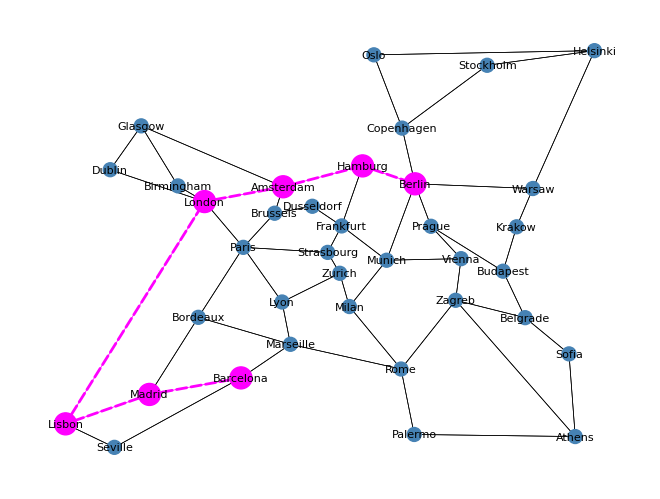

In [14]:
# Create the digraph with nodes and links attributes
G = nx.DiGraph()

lnodes=list((i,{'lat':instance.latitude[i], 'long':instance.longitude[i]}) for i in list(instance.V))
G.add_nodes_from(lnodes)

ledges = list((i,j,{'cap':instance.capacity[i,j]}) for i,j in list(instance.E))
G.add_edges_from(ledges)

# Position of nodes according to latitude and longitude
node_pos = {i:(instance.latitude[i], instance.longitude[i]) for i in list(instance.V)}

# Print results
print_results(instance)
path = get_path(instance)

# Show paths on the graph
show_paths(path,'magenta',node_pos)

In [15]:
print(util,en)

[0.291630212890055, 0.291630212890055, 0.291630212890055] [6.0, 6.0, 6.0]


ep1=.22, ep2=8. point=(0.21, 7.0) with MaxUtilization activated. </span>

PATH:  ['Barcelona', 'Madrid', 'Bordeaux', 'Marseille', 'Rome', 'Milan', 'Munich', 'Berlin'] </span>

ep1=.6, ep2=7. point=(0.46,5.0) with MaxEnergy activated.</span>

PATH:  ['Barcelona', 'Marseille', 'Rome', 'Milan', 'Munich', 'Berlin'] </span>

ep1=.4, ep2=5. point=(0.46,5.0) with MaxUtilization activated. </span>

PATH:  ['Barcelona', 'Seville', 'Lisbon', 'London', 'Amsterdam', 'Hamburg', 'Berlin']

### <font color=blue><b>EXERCISE 4</b></font>.-

#### Use the Goal Attainment Method to find the path. What are the goals of each objective function? Indicate what are the results for each goal. What is the value and what represents $\lambda$?

In [45]:
######################
## CREATE THE MODEL ##
######################

model = AbstractModel()

######################
## MODEL PARAMETERS ##
######################

# Set of network nodes
model.V = Set()

# Set of network edges
model.E = Set(dimen=2)

# Latitude and longitude of nodes
model.latitude = Param(model.V, within=Any)
model.longitude = Param(model.V, within=Any)

# Flow capacity limits of links
model.capacity = Param(model.E, within=NonNegativeReals)

# Weight or cost of each link
model.linkcost = Param(model.E, within=NonNegativeReals)

# Set of Demands
model.D = Set()

# Source nodes
model.source = Param(model.D, within=Any)

# Destination nodes
model.destination = Param(model.D, within=Any)

# Traffic demand value
model.demand = Param(model.D, within=NonNegativeIntegers)

# Target values for each objective
model.Target_Energy = Param(within=NonNegativeIntegers, initialize=7)  # Target for Energy consumption
model.Target_Utilization = Param(within=NonNegativeReals, initialize=0.22)  # Target for Utilization

#####################
## MODEL VARIABLES ##
#####################

# If x[i,j]=1, link (i,j) is used
model.x = Var(model.E, within=Binary, initialize=0)

# if f[i,j,d]=1, link (i,j) is used for demand d
model.f = Var(model.E, model.D, within=Binary, initialize=0)

# Energy savings (number of active links)
model.Energy = Var(within=NonNegativeIntegers, initialize=0)

# Maximum link Utilization
model.Utilization = Var(within=NonNegativeReals, bounds=(0,1), initialize=0)

# Lambda variable representing the compromise level
model.lamda = Var(within=NonNegativeReals, initialize=0)

########################
## OBJECTIVE FUNCTION ##
########################

# Minimize lambda (the compromise factor)
def GoalAttainment_rule(model):
    return model.lamda

model.GoalAttainment = Objective(rule=GoalAttainment_rule, sense=minimize)

#################
## CONSTRAINTS ##
#################

# Flow conservation constraint at each node
def flow_rule(model, k, d):
    inFlow  = sum(model.f[j, i, d] for (j, i) in model.E if i == k)
    if (k == model.source[d]):
        inFlow = inFlow + 1

    outFlow = sum(model.f[i, j, d] for (i, j) in model.E if i == k)
    if (k == model.destination[d]):
        outFlow = outFlow + 1

    return inFlow == outFlow

model.flow = Constraint(model.V, model.D, rule=flow_rule)

# Active links constraint
def activelinks_rule(model, i, j):
    return sum(model.f[i, j, d] * model.demand[d] for d in model.D) <= model.x[i, j] * model.capacity[i, j]

model.activelinks = Constraint(model.E, rule=activelinks_rule)

# Utility constraint
def Utility_rule(model, i, j):
    return model.Utilization >= (sum(model.f[i, j, d] * model.demand[d] for d in model.D)) / model.capacity[i, j]

model.Utility = Constraint(model.E, rule=Utility_rule)

# Energy constraint
def EnergyC_rule(model):
    return model.Energy == sum(model.x[i, j] for (i, j) in model.E)

model.EnergyC = Constraint(rule=EnergyC_rule)

#########################
## GOAL CONSTRAINTS WITH LAMBDA ##
#########################

# Energy constraint reformulated with lambda
def EnergyGoal_rule(model):
    return model.Energy <= model.Target_Energy * (1 + model.lamda)

model.EnergyGoal = Constraint(rule=EnergyGoal_rule)

# Utilization constraint reformulated with lambda
def UtilizationGoal_rule(model):
    return model.Utilization <= model.Target_Utilization * (1 + model.lamda)

model.UtilizationGoal = Constraint(rule=UtilizationGoal_rule)

opt = SolverFactory('glpk')
instance = model.create_instance('./OPTIM-OPTECH-ProjectSession3.dat')
results = opt.solve(instance)
instance.solutions.load_from(results)


# util = []
# en = []
util.append(instance.Utilization.value)
en.append(instance.Energy.value)


UTILIZATION PER LINK
Link (Barcelona, Madrid) 14.62%
Link (Bordeaux, Marseille) 14.70%
Link (Madrid, Bordeaux) 13.32%
Link (Marseille, Rome) 12.25%
Link (Milan, Munich) 21.29%
Link (Munich, Berlin) 14.68%
Link (Rome, Milan) 15.43%

PATH:  ['Barcelona', 'Madrid', 'Bordeaux', 'Marseille', 'Rome', 'Milan', 'Munich', 'Berlin'] 



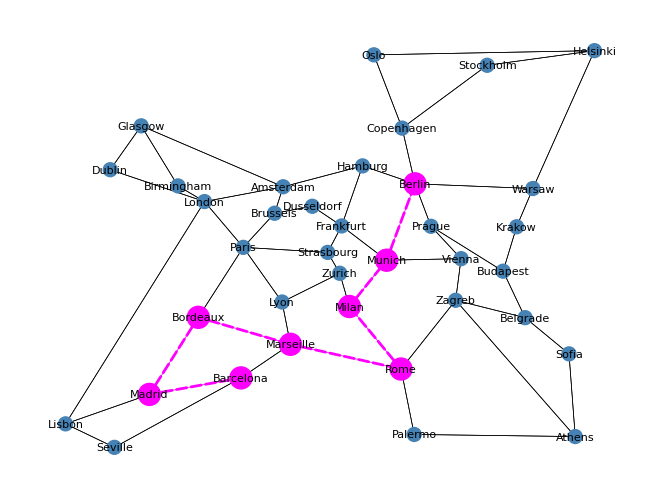

In [46]:
# Create the digraph with nodes and links attributes
G = nx.DiGraph()

lnodes=list((i,{'lat':instance.latitude[i], 'long':instance.longitude[i]}) for i in list(instance.V))
G.add_nodes_from(lnodes)

ledges = list((i,j,{'cap':instance.capacity[i,j]}) for i,j in list(instance.E))
G.add_edges_from(ledges)

# Position of nodes according to latitude and longitude
node_pos = {i:(instance.latitude[i], instance.longitude[i]) for i in list(instance.V)}

# Print results
print_results(instance)
path = get_path(instance)

# Show paths on the graph
show_paths(path,'magenta',node_pos)

In [47]:
print(util,en)

[0.464900046490005, 0.3, 0.23, 0.464900046490005, 0.464900046490005, 0.291630212890055, 0.22] [5.0, 6.0, 7.0, 5.0, 5.0, 6.0, 7.0]


.22,5-----(.29, 6) PATH:  PATH:  ['Barcelona', 'Madrid', 'Lisbon', 'London', 'Amsterdam', 'Hamburg', 'Berlin']
.5,5----(.46,5) PATH:  ['Barcelona', 'Marseille', 'Rome', 'Milan', 'Munich', 'Berlin']
.22,7---(.22,7) PATH:  ['Barcelona', 'Madrid', 'Bordeaux', 'Marseille', 'Rome', 'Milan', 'Munich', 'Berlin']

1. Goals of Each Objective:

    Energy Consumption: Minimize the number of active links (energy cost).
    Link Utilization: Minimize the maximum utilization of any link (avoid congestion).

2. Results for Each Goal:

    Target (0.22, 5) → Pareto (0.29, 6): Path = ['Barcelona', 'Madrid', 'Lisbon', 'London', 'Amsterdam', 'Hamburg', 'Berlin']
    Target (0.5, 5) → Pareto (0.46, 5): Path = ['Barcelona', 'Marseille', 'Rome', 'Milan', 'Munich', 'Berlin']
    Target (0.22, 7) → Pareto (0.22, 7): Path = ['Barcelona', 'Madrid', 'Bordeaux', 'Marseille', 'Rome', 'Milan', 'Munich', 'Berlin']

3. λ (Lambda):

    λ measures how much the objectives deviate from their targets. Minimizing λ minimizes these deviations. A λ of 0 means the goals are exactly met; higher λ indicates a trade-off between energy and utilization goals.